# hVAE

In [ ]:
from src.hvae import hVAE

PATH = "path"

hvae = hVAE.load(PATH)
hvae.eval()
hvae.generate(10)

In [3]:
from torch import nn

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


vae = VAE()
for p in vae.parameters():
    print(p.shape)

torch.Size([400, 784])
torch.Size([400])
torch.Size([20, 400])
torch.Size([20])
torch.Size([20, 400])
torch.Size([20])
torch.Size([400, 20])
torch.Size([400])
torch.Size([784, 400])
torch.Size([784])


In [45]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph():
    G = nx.DiGraph()

    encoder_edges = [('x', 'z1'), ('y', 'z1'), ('x', 'y')]
    decoder_edges = [('z1', 'x'), ('y', 'z1')]

    # use the same node list for both nx.draw calls
    nodes = ['x', 'y', 'z1']

    # specify the positions of the nodes
    pos = {'x': (0, 0), 'z1': (0, 1), 'y': (0, 2)}

    nx.draw(G, nodelist=nodes, pos=pos, edgelist=encoder_edges, edge_color="r", width=2, node_size=2000, with_labels=True, node_color="lightblue", ax=plt.gca(), arrowstyle="->", connectionstyle="arc3,rad=0.2")

    # draw the blue edges with labels and arrows on the same axis with negative curvature
    nx.draw(G, nodelist=nodes, pos=pos, edgelist=decoder_edges, edge_color="b", width=2, node_size=2000, with_labels=True, node_color="lightblue", ax=plt.gca(), arrowstyle="->")
    # show the plot
    plt.show()


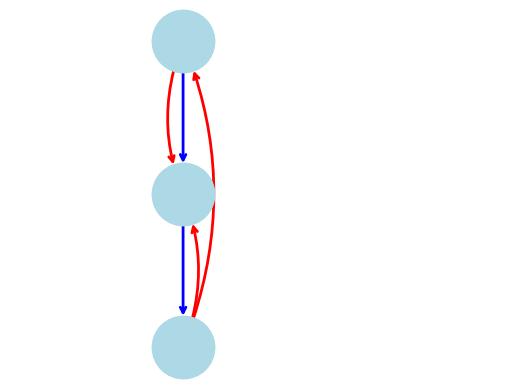

In [46]:
visualize_graph()

In [1]:
from hparams import get_hparams

hparams = get_hparams()
model = hparams.model_params.model()

In [2]:
for param in model.parameters():
    print(param)

RuntimeError: Could not infer dtype of generator

In [1]:
from test import main

main()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 200 but got size 784 for tensor number 1 in the list.

In [5]:
model.encoder.encoder_blocks['x'].input

In [36]:
from torchinfo import summary
from src.elements.nets import get_net
from hparams import Hyperparams
import torch

net = get_net(Hyperparams(
    type='mlp',
    input_size=784,
    hidden_sizes=[2000],
    output_size=1000,
    activation=torch.nn.ReLU(),
    residual=False
))
summary(net, (1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1000]                 --
├─MLPNet: 1-1                            [1, 1000]                 --
│    └─Sequential: 2-1                   [1, 1000]                 --
│    │    └─Linear: 3-1                  [1, 2000]                 1,570,000
│    │    └─ReLU: 3-2                    [1, 2000]                 --
│    │    └─Linear: 3-3                  [1, 1000]                 2,001,000
Total params: 3,571,000
Trainable params: 3,571,000
Non-trainable params: 0
Total mult-adds (M): 3.57
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 14.28
Estimated Total Size (MB): 14.31

In [17]:
from torch import nn
x: nn.Module = model.encoder.encoder_blocks['x'].net

In [31]:
x.

AttributeError: 'ModelStatistics' object has no attribute 'parameters'

In [23]:
model.encoder.encoder_blocks['x'].net(None)

In [26]:
summary(model.encoder.encoder_blocks['x'], (1000, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #


AttributeError: 'int' object has no attribute 'numpy'

In [2]:
from train import main

main()

KeyError: 'load_from'

In [2]:
exp = Experiment.load("test.pth")

In [3]:
exp

None
